# Alignment Error Visualization

This notebook collects COM data from the database and tries to quantify some alignment errors. The main results are shown in the plots at the end of the notebook.

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from collections import OrderedDict
from IPython.display import HTML
from itertools import combinations

PIPELINE_ROOT = Path('./').absolute().parents[1]
PIPELINE_ROOT = PIPELINE_ROOT.as_posix()
sys.path.append(PIPELINE_ROOT)
print(PIPELINE_ROOT)


/home/eddyod/programming/pipeline/src


In [2]:
from library.controller.sql_controller import SqlController
from library.image_manipulation.filelocation_manager import FileLocationManager
from library.atlas.atlas_utilities import apply_affine_transform, get_affine_transformation, list_coms, \
    compute_affine_transformation, compute_affine_transformation_centroid
from library.atlas.brain_structure_manager import BrainStructureManager
from library.utilities.utilities_process import M_UM_SCALE, SCALING_FACTOR, random_string, \
read_image, write_image


xgboost version=2.1.4


In [3]:
def absolute_sum(l):
    la = np.array(l)
    nabs = (np.array(la*la))
    return np.sum(la, axis=0)

def sum_square_com(com):
    ss = np.sqrt(sum([s*s for s in com]))
    return ss

def generate_combinations(lst):
    """
    Generate all combinations of at least 3 elements from the given list.
    
    :param lst: List of elements
    :return: List of tuples containing the combinations
    """
    return list(combinations(lst, 5 ))

    #result = []
    #for r in range(3, len(lst) + 1):
    #    result.extend(combinations(lst, r))
    #return result



In [20]:
atlas_all = list_coms('AtlasV7')
allen_all = list_coms('Allen')
common_keys = list(atlas_all.keys() & allen_all.keys())
atlas_common = np.array([atlas_all[s] for s in common_keys])
allen_common = np.array([allen_all[s] for s in common_keys])
print(len(common_keys))

37


In [5]:
base_keys = ['LRt_L', 'LRt_R', 'SC', 'IC']
test_keys = ['PBG_L', 'PBG_R', 'SC', 'IC', '4N_L', '4N_R', 'LRt_L','LRt_R', 'SNC_L', 'SNC_R', ]
bad_keys = ['RtTg','AP']
good_keys = set(common_keys) - set(bad_keys)
print(len(base_keys))
print(len(test_keys))
print(len(bad_keys))
print(len(good_keys))
print(len(common_keys))

4
10
2
35
37


In [21]:
atlas_src = np.array([atlas_all[s] for s in common_keys])
allen_src = np.array([allen_all[s] for s in common_keys])
transformation_matrix = compute_affine_transformation(atlas_src, allen_src)
transformation_matrix

array([[ 9.42279538e-01,  5.07770162e-02,  4.02430133e-03,
         1.67617121e+02],
       [-1.30121150e-03,  1.19394497e+00,  7.16889453e-03,
        -8.14323008e+01],
       [-1.50092611e-02,  8.60586632e-03,  1.12982209e+00,
        -6.62364827e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [22]:
df_list = []
error = []
transformed_dict = {}
for structure in common_keys:
    atlas0 = np.array(atlas_all[structure])
    allen0 = np.array(allen_all[structure]) 
    transformed = apply_affine_transform(atlas0, transformation_matrix)
    transformed = [round(x,4) for x in transformed]
    difference = [round(a - b,4) for a, b in zip(transformed, allen0)]
    ss = sum_square_com(difference)
    row = [structure, atlas0, allen0, transformed, difference, ss]
    df_list.append(row)
    error.append(ss)
    transformed_dict[structure] = transformed
print('RMS', sum(error)/len(df_list))
# test keys RMS 25.61709479307028
# base keys RMS 25.602246865972344

RMS 25.996035162247185


In [23]:
print(atlas_all['SC'])
print(allen_all['SC'])
print(transformed_dict['SC'])

(777.58, 265.35, 573.0)
(914.05, 238.8, 569.25)
[916.0945, 238.477, 571.7642]


In [24]:
columns = ['structure', 'atlas0', 'allen0', 'transformed', 'difference', 'sumsquares']
df = pd.DataFrame(df_list, columns=columns)
df.index.name = 'Index'
df.sort_values(by=['structure'], inplace=True)
HTML(df.to_html(index=False))

structure,atlas0,allen0,transformed,difference,sumsquares
3N_L,"[775.63, 391.54, 557.44]","[910.25, 379.44, 552.1]","[920.6019, 389.0319, 555.2995]","[10.3519, 9.5919, 3.1995]",14.470770
3N_R,"[775.63, 391.54, 582.56]","[910.34, 379.4, 586.44]","[920.703, 389.212, 583.6806]","[10.363, 9.812, -2.7594]",14.535522
4N_L,"[809.24, 396.73, 545.23]","[958.86, 377.78, 543.25]","[952.4864, 395.0972, 541.0445]","[-6.3736, 17.3172, -2.2055]",18.584198
4N_R,"[809.24, 396.73, 594.77]","[958.68, 377.48, 595.29]","[952.6857, 395.4523, 597.0159]","[-5.9943, 17.9723, 1.7259]",19.024036
5N_L,"[866.79, 502.13, 432.89]","[1019.3, 528.65, 409.16]","[1011.6143, 520.0588, 414.1636]","[-7.6857, -8.5912, 5.0036]",12.566412
5N_R,"[866.79, 502.13, 707.11]","[1019.34, 528.55, 729.28]","[1012.7179, 522.0246, 723.9834]","[-6.6221, -6.5254, -5.2966]",10.699861
6N_L,"[926.23, 512.4, 533.79]","[1077.12, 521.48, 529.09]","[1068.551, 532.9666, 527.3589]","[-8.569, 11.4866, -1.7311]",14.434904
6N_R,"[926.23, 512.4, 606.21]","[1077.14, 521.46, 609.41]","[1068.8424, 533.4857, 609.1806]","[-8.2976, 12.0257, -0.2294]",14.612332
7N_L,"[939.45, 615.73, 455.77]","[1085.27, 677.54, 434.0]","[1085.9407, 655.7604, 439.901]","[0.6707, -21.7796, 5.901]",22.574823
7N_R,"[939.45, 615.73, 684.23]","[1085.26, 677.53, 704.52]","[1086.8601, 657.3982, 698.0201]","[1.6001, -20.1318, -6.4999]",21.215522


In [10]:
df['sumsquares'].sum()/len(df.index)

25.99603516224719

In [49]:
structure = 'SC'
animal = 'MD589'
original_path = f'/media/eddyod/orangepassport/birdstore/Active_Atlas_Data/data_root/atlas_data/{animal}/structure/{structure}.npy'
new_path = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/{animal}/structure/{structure}.npy'
ori_arr = np.load(original_path)
new_arr = np.load(new_path)
print(f'original {ori_arr.shape}')
print(f'new {new_arr.shape}')

original (157, 104, 182)
new (156, 106, 182)


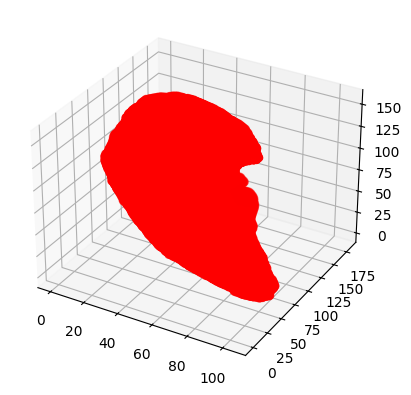

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

volume = new_arr.copy()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z,x,y = volume.nonzero()
ax.scatter(x, y, z, zdir='y', c= 'red')
plt.show()